In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice


%matplotlib inline

### First, let's load up some Gaia data

We will use the same Gaia data from last week, so it contains the Pleiades within it.

In [145]:
data = np.load('Gaia_DR2_sample.npy')

print(data.shape)  # Number of stars
print(data.dtype.names)  # Variables in the array

(10396,)
('source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag')


### Let's look at the data

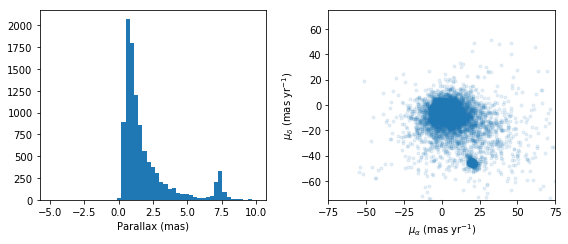

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))


# Parallax
bins = np.linspace(-5, 10, 50)
ax[0].hist(data['parallax'], bins=bins)
ax[0].set_xlabel('Parallax (mas)')


# Proper motion
ax[1].scatter(data['pmra'], data['pmdec'], marker='.', alpha=0.1)
ax[1].set_xlabel(r'$\mu_{\alpha}$ (mas yr$^{-1}$)')
ax[1].set_ylabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)')
ax[1].set_xlim(-75, 75)
ax[1].set_ylim(-75, 75)


plt.tight_layout()
plt.show()

### Our function to calculate absolute magnitudes

In [218]:
def get_absolute_mag(apparent_magnitude, parallax):
    """ This function calculates the absolute magnitude from the apparent
    magnitude and the astrometric parallax
    
    Arguments
    ---------
    apparent_magnitude : float (mag)
        The apparent magnitude of the star. This can be in any band
        
    parallax : float (mas)
        The astrometric parallax of the star.
        
    Returns
    -------
    absolute_magnitude : float
        The absolute magnitude of the star
    """
    
    absolute_magnitude = apparent_magnitude - 5.0 * np.log10(1.0e2/parallax)
    
    return absolute_magnitude

### Now, let's plot a CMD

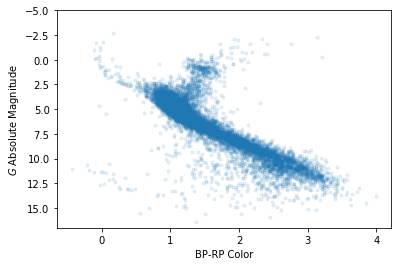

In [148]:
G_abs = get_absolution_mag(data['phot_g_mean_mag'], data['parallax'])
BP_RP_color = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']

plt.scatter(BP_RP_color, G_abs, marker='.', alpha=0.1)

plt.xlabel('BP-RP Color')
plt.ylabel(r'$G$ Absolute Magnitude')

plt.ylim(17, -5)

plt.show()

### Now, let's identify Pleiades members using one of our clustering algorithms

In [149]:
# Create data array - we want to identify cluster members using parallax and proper motions
X = np.zeros((len(data), 3))

X[:,0] = data['parallax']*5.
X[:,1] = data['pmra']
X[:,2] = data['pmdec']

### Pick a model and run it

In [260]:
# model_name = ''
# model = 


# DBSCAN
model = cluster.DBSCAN(eps=5, min_samples=15)

# Gaussian mixture model
# model_name = 'Gaussian Mixture Model'
# n_components = 10
# model = mixture.GaussianMixture(n_components=n_components, covariance_type='full')

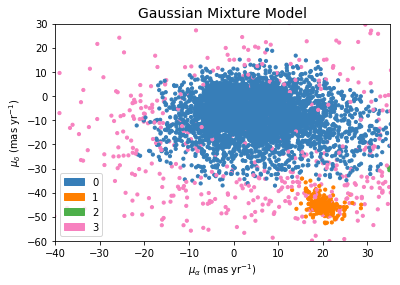

In [261]:
# Fit mixture model
model.fit(X)


# Get classifiers
if hasattr(model, 'labels_'):
    y_pred = model.labels_.astype(np.int)
else:
    y_pred = model.predict(X)


# Add a title to denote which model we ran
plt.title(model_name, size=14)

# In case some y_pred are negative
y_pred[y_pred == -1] = np.max(y_pred) + 1

# Set a series of colors, so we don't run out
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))


# Plot points
plt.scatter(X[:, 1], X[:, 2], s=10, color=colors[y_pred])


# Plot range
plt.xlim(-40, 35)
plt.ylim(-60, 30)

# Plot labels
plt.xlabel(r'$\mu_{\alpha}$ (mas yr$^{-1}$)')
plt.ylabel(r'$\mu_{\delta}$ (mas yr$^{-1}$)')

# Color labels
patches = []
for i in range(len(np.unique(y_pred))):
    patches.append(mpatches.Patch(color=colors[i], label=str(i)))


plt.legend(handles=patches)

    
plt.show()

### Plot CMD of non-Pleiades stars

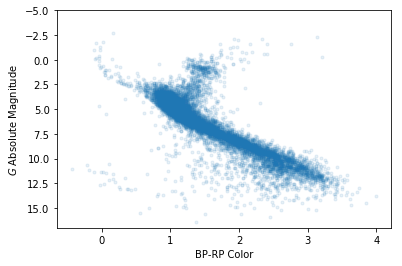

In [262]:
# Determine absolute magnitude - unextincted
G_abs = get_absolute_mag(data['phot_g_mean_mag'], data['parallax'])

# Determine color - unreddened
BP_RP_color = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']


# All stars not part of Pleiades
plt.scatter(BP_RP_color[y_pred!=idx], G_abs[y_pred!=idx], marker='.', alpha=0.1)

plt.xlabel('BP-RP Color')
plt.ylabel(r'$G$ Absolute Magnitude')

plt.ylim(17, -5)

plt.show()

### Plot CMD of Pleiades stars, with isochrones

In [263]:
# Load up isochrones from MIST models
isochrones_Z000 = np.load("./Gaia_bands_young_Z000.npy")
isochrones_Z025 = np.load("./Gaia_bands_young_Z025.npy")
isochrones_Z050 = np.load("./Gaia_bands_young_Z050.npy")

# Extinction and reddening of the Pleiades
A_G = 0.25
A_BP = 0.28
A_RP = 0.13
E_BP_RP = A_BP - A_RP

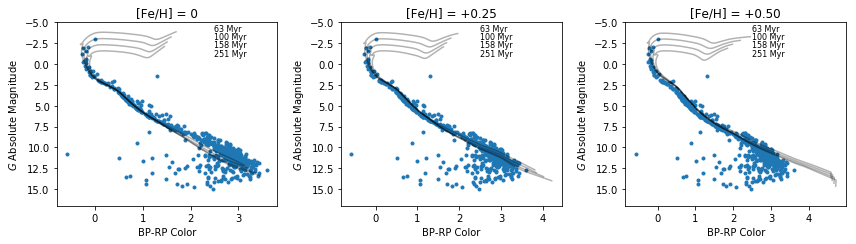

In [266]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

# Determine absolute magnitude - unextincted
G_abs = get_absolute_mag(data['phot_g_mean_mag'], data['parallax']) - A_G

# Determine color - unreddened
BP_RP_color = data['phot_bp_mean_mag'] - data['phot_rp_mean_mag'] - E_BP_RP



##### Plieades stars #####
idx = 1 # Index for Pleiades class from classification

for j in range(3):

    # Plot CMD
    ax[j].scatter(BP_RP_color[y_pred==idx], G_abs[y_pred==idx], marker='.')

    ax[j].set_xlabel('BP-RP Color')
    ax[j].set_ylabel(r'$G$ Absolute Magnitude')

    ax[j].set_ylim(17, -5)


    
titles = ['[Fe/H] = 0', '[Fe/H] = +0.25', '[Fe/H] = +0.50']
    
for j, isochrones in enumerate([isochrones_Z000, isochrones_Z025, isochrones_Z050]):

    ##### Plot Isochrones #####
    for i, age in enumerate(np.unique(isochrones['age'])):
        color = isochrones[isochrones['age']==age]['Gaia_BP'] - isochrones[isochrones['age']==age]['Gaia_RP']
        magnitude = isochrones[isochrones['age']==age]['Gaia_G']

        ax[j].plot(color, magnitude, color='k', alpha=0.3)
        ax[j].text(2.5, -4.0+i, "%.0f"%10**(age-6.0) + ' Myr', fontsize=8)
    
        ax[j].set_title(titles[j])

    

plt.tight_layout()
plt.show()

### What is the age, metallicity, and reddening of the Pleiades???